## Image classification with Convolutional Neural Networks

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/invasivespecies/"

In [ ]:
sz=600

### Extra steps if NOT using Crestle or our scripts

The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. `wget http://files.fast.ai/data/dogscats.zip`. You should put the data in a subdirectory of this notebook's directory, called `data/`.

In [ ]:
csv_path = PATH+'train_labels.csv'
df = pd.read_csv(csv_path)

In [ ]:
print(df.columns)
print(df.shape)

In [ ]:
df.head()

## First look at Plant pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [ ]:
!ls {PATH}

In [ ]:
!ls {PATH}valid

In [ ]:
files = !ls {PATH}train | head
files

In [ ]:
test_file = PATH+'train/'+str(df['name'][0])+'.jpg'
print(test_file)
test_img = plt.imread(test_file)
plt.imshow(test_img)
# PIL.Image.open(test_file)

Here is how the raw data looks like

In [ ]:
test_img.shape

In [ ]:
test_img[:4,:4]

In [ ]:
shape_map = { k:plt.imread(f'{PATH}train/{k}.jpg').shape for k in df.name }

In [ ]:
h, w, c = zip(*shape_map.values())

In [ ]:
# f = plt.figure()
# f = plt.subplot(1,2,1, figsize=(2,2))
f, [ax1, ax2] = plt.subplots(1,2, figsize=(12,4))
ax1.hist(w)
# f = plt.subplot(1,2,2, figsize=(2,2))
ax2.hist(h)

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [ ]:
# Uncomment the below if you need to reset your precomputed activations
# !rm -rf {PATH}tmp

In [ ]:
n = df.shape[0]-1
val_idxs = get_cv_idxs(n)
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=csv_path, num_workers=4, 
                                        tfms=tfms, suffix='.jpg', test_name='test', val_idxs=val_idxs, skip_header=True, bs=bs)
    return data.resize(sz, 'tmp')

In [ ]:
arch = resnet34
data = get_data(sz, 64)


In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)


In [ ]:
learn.fit(1e-2, 2)

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [ ]:
# This is the label for a val data
data.val_y

In [ ]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

In [ ]:
log_preds[:10]

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct Noninvasive")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct Invasive")

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Noninvasive")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Invasive")

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
lrf=learn.lr_find()

Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

In [ ]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

In [ ]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

In [ ]:
learn.fit(1e-2, 3)

## Improving our model

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizaing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [ ]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [ ]:
# def get_augs():
#     data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
#     x,_ = next(iter(data.aug_dl))
#     return data.trn_ds.denorm(x)[1]

n = df.shape[0]-1
val_idxs = get_cv_idxs(n)
def get_augs():
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=csv_path, num_workers=2, 
                                        tfms=tfms, suffix='.jpg', test_name='test', val_idxs=val_idxs, skip_header=True, bs=2)
    
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
#     return data.resize(sz, 'tmp')

In [ ]:
ims = np.stack([get_augs() for i in range(6)])

In [ ]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [ ]:
data = get_data(sz, 64)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
learn.fit(1e-2, 3)

In [ ]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

In [ ]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [ ]:
learn.save('600_lastlayer')

In [ ]:
learn.load('600_lastlayer')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [ ]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

In [ ]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [ ]:
learn.save('600_all')

In [ ]:
learn.load('600_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [ ]:
log_preds_train,y_train = learn.TTA()

# probs = np.mean(np.exp(log_preds),0)

In [ ]:
print(log_preds_train.shape)
print(y_train.shape)

In [ ]:
probs = np.mean(np.exp(log_preds_train),0)

In [ ]:
accuracy(probs, y)

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

In [ ]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Noninvasive")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Invasive")

### Submission

In [ ]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [ ]:
probs.shape

In [ ]:
# data.test_ds.fnames


In [ ]:
ds = pd.DataFrame(probs)
ds.columns = data.classes

In [ ]:
ds.insert(0, 'name', [o[len('test/'):-len('.jpg')] for o in data.test_ds.fnames])
ds.drop(columns='0', axis=1, inplace=True)
ds.rename(columns={'1':'invasive'}, inplace=True)

In [ ]:
ds.head()

In [ ]:
ds.shape

In [ ]:
SUBM_FOLDER = f'{PATH}subm/'
SUBM_FILE = f'{SUBM_FOLDER}subm.gz'
os.makedirs(SUBM_FOLDER, exist_ok=True)
ds.to_csv(SUBM_FILE, compression='gzip', index=False)

In [ ]:
test_csv_path = PATH+'test_labels.csv'
ds.to_csv(test_csv_path, index=False)

In [ ]:
FileLink(SUBM_FILE)

## Combining test data predictions and running model again

### Creating dataframe

In [ ]:
df_test = pd.read_csv(test_csv_path)
df_train = pd.read_csv(train_csv_path)

In [ ]:
df_test.head()

In [ ]:
df_test['invasive'] = df_test.invasive.round()

In [ ]:
df_test.name = df_test.name.apply(lambda x: 'test-'+str(x), convert_dtype=True)

In [ ]:
df_all = pd.concat([df_test, df_train])
print(df_all.shape)
print(df_test.shape)
print(df_train.shape)

In [ ]:
all_csv_path = PATH+'all_labels.csv'
df_all.to_csv(all_csv_path, index=False)

### Move images to all

In [ ]:
%mkdir "{PATH}all"

In [ ]:
%cp "{PATH}train/"* "{PATH}all"

In [ ]:
# Append "test-" suffix to test images and move to all folder
import shutil
import os

_, _, filenames = next(os.walk(f'{PATH}test'))
for f in filenames:
#     print(f'{PATH}test/{f}')
#     print(f'{PATH}all/test-{f}')
    shutil.copyfile(f'{PATH}test/{f}', f'{PATH}all/test-{f}')

### Checking dimensions

In [ ]:
print(df_all.shape)
_, _, filenames = next(os.walk(f'{PATH}all'))
print(len(filenames))

### Running data on new frame

In [ ]:
# Uncomment the below if you need to reset your precomputed activations
# !rm -rf {PATH}tmp

In [5]:
all_csv_path = PATH+'all_labels.csv'
df_all = pd.read_csv(all_csv_path)

In [6]:
n = df_all.shape[0]-1
val_idxs = get_cv_idxs(n, val_pct=.1)
sz = 520
arch = resnet50
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path=PATH, folder='all', csv_fname=all_csv_path, num_workers=4, 
                                        tfms=tfms, suffix='.jpg', test_name='test', val_idxs=val_idxs, skip_header=True, bs=bs)
    return data.resize(sz, 'tmp')

In [7]:
data = get_data(sz, 32)


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [10]:
learn = ConvLearner.pretrained(arch, data)

In [11]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  2%|▏         | 2/108 [00:01<01:41,  1.04it/s, loss=1.04]  


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 85%|████████▌ | 92/108 [00:59<00:10,  1.54it/s, loss=2.42] 


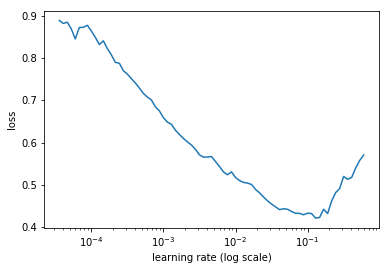

In [13]:
learn.sched.plot()

In [14]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[0.      0.22726 0.11947 0.95312]                            
[1.      0.1807  0.09677 0.97118]                            



In [15]:
learn.pretrained=False

In [16]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.15333 0.0975  0.96319]                            
[1.      0.1497  0.0881  0.96875]                            
[2.      0.14803 0.08144 0.96597]                            



In [18]:
learn.save(f'{sz}_trainandtest_last_layer')

In [ ]:
learn.load(f'{sz}_trainandtest_last_layer')

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [19]:
learn.unfreeze()

In [20]:
lr=np.array([1e-4,1e-3,1e-2])

In [21]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.15551 0.06094 0.97899]                            
[1.      0.10061 0.05781 0.97899]                            
[2.      0.07151 0.058   0.97622]                             
[3.      0.07292 0.04324 0.97639]                             
[4.      0.04385 0.05513 0.97587]                             
[5.      0.03186 0.04616 0.98385]                             
[6.      0.03958 0.04211 0.98906]                             



Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

In [ ]:
learn.sched.plot()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [22]:
learn.save('660_trainandtest_all')

In [ ]:
learn.load('660_trainandtest_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [ ]:
log_preds_train,y_train = learn.TTA()

# probs = np.mean(np.exp(log_preds),0)

### Submission

In [23]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [24]:
probs.shape

(1531, 2)

In [ ]:
# data.test_ds.fnames


In [25]:
ds = pd.DataFrame(probs)
ds.columns = data.classes

In [27]:
ds.head()

,name,0.0,1.0
0,146,0.001918,0.998082
1,1127,0.999982,0.000018
2,962,0.000006,0.999995
3,82,0.992644,0.007356
4,1366,0.999170,0.000830


In [29]:
ds.insert(0, 'name', [o[len('test/'):-len('.jpg')] for o in data.test_ds.fnames])
ds.drop(columns='0.0', axis=1, inplace=True)
ds.rename(columns={'1.0':'invasive'}, inplace=True)

In [30]:
ds.head()

,name,invasive
0,146,0.998082
1,1127,0.000018
2,962,0.999995
3,82,0.007356
4,1366,0.000830


In [32]:
SUBM_FOLDER = f'{PATH}subm/'
SUBM_FILE = f'{SUBM_FOLDER}subm_all.gz'
os.makedirs(SUBM_FOLDER, exist_ok=True)
ds.to_csv(SUBM_FILE, compression='gzip', index=False)

In [ ]:
test_csv_path = PATH+'test_labels.csv'
ds.to_csv(test_csv_path, index=False)

In [36]:
FileLink(SUBM_FILE)

/home/paperspace/fastai/courses/dl1/data/invasivespecies/subm/subm_all.gz

In [33]:
ds_clipped = ds.copy()
ds_clipped['invasive'] = ds_clipped.invasive.clip(lower=0.05, upper=0.95)

In [34]:
ds_clipped.shape

(1531, 2)

In [35]:
SUBM_FILE_CLIPPED = f'{SUBM_FOLDER}subm_all_clipped.gz'
os.makedirs(SUBM_FOLDER, exist_ok=True)
ds_clipped.to_csv(SUBM_FILE_CLIPPED, compression='gzip', index=False)

In [38]:
FileLink(SUBM_FILE_CLIPPED)

/home/paperspace/fastai/courses/dl1/data/invasivespecies/subm/subm_all_clipped.gz

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

### Tips and Tricks

In [ ]:
trn_tfms,val_tfms = tfms_from_model(arch, sz)

In [ ]:
im = val_tfms(Image.open(PATH+fn))
preds = learn.predict_array(im[None])
np.argmax(preds)